In [5]:
"""
Ghana FX Rate Prediction using LSTM
"""

# Import required libraries
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [7]:
df = pd.read_csv('datasets/cleaned/merged_fx_dataset.csv')

print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)
print(f"\nMissing values:")
print(df.isnull().sum())
print(f"\nBasic statistics:")
print(df.describe())


Dataset shape: (4217, 14)

First few rows:
         Date   Buying  Selling  MidRate   MPR  GhInflationRate  BrentOil  \
0  2024-12-31  14.6927  14.7074    14.70  27.0            23.82     73.18   
1  2024-12-30  14.7026  14.7174    14.71  27.0            23.82     73.18   
2  2024-12-27  14.6927  14.7074    14.70  27.0            23.82     73.18   
3  2024-12-24  14.6427  14.6573    14.65  27.0            23.82     73.18   
4  2024-12-23  14.6427  14.6573    14.65  27.0            23.82     73.18   

      Cocoa     Gold  GhInterestRate    GhGDP      USGDP  USInflationRate  \
0  10869.14  2641.45           27.03  53957.1  23542.349           123.98   
1  10869.14  2641.45           27.03  53957.1  23542.349           123.98   
2  10869.14  2641.45           27.03  53957.1  23542.349           123.98   
3  10869.14  2641.45           27.03  53957.1  23542.349           123.98   
4  10869.14  2641.45           27.03  53957.1  23542.349           123.98   

   USInterestRate  
0         

In [10]:
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# # Clean numeric columns (some might be strings)
# numeric_cols = ['Buying', 'GDP', 'Interbank weighted average rate',
#                 'Monetary policy rate', 'Oil_Price', 'Cocoa_Price',
#                 'Gold_Price', 'Headline Inflation']

# for col in numeric_cols:
#     df[col] = pd.to_numeric(df[col], errors='coerce')

# # Remove rows with missing critical values
# print(f"\nRows before cleaning: {len(df)}")
# df = df.dropna(subset=['Buying', 'Date'])
# df = df.sort_values('Date').reset_index(drop=True)
# print(f"Rows after cleaning: {len(df)}")

# # Fill remaining missing values with forward fill then backward fill
# df = df.fillna(method='ffill').fillna(method='bfill')

In [9]:
df.columns

Index(['Date', 'Buying', 'Selling', 'MidRate', 'MPR', 'GhInflationRate',
       'BrentOil', 'Cocoa', 'Gold', 'GhInterestRate', 'GhGDP', 'USGDP',
       'USInflationRate', 'USInterestRate'],
      dtype='object')

In [17]:
# Create a copy for feature engineering
data = df.copy()

# 1. LAG FEATURES (Historical dependencies)
print("\n1. Creating lag features...")
data['BuyingLag1'] = data['Buying'].shift(1)
data['BuyingLag7'] = data['Buying'].shift(7)
data['GhInterestRateLag1'] = data['GhInterestRate'].shift(1)
# data['mpr_lag1'] = data['MPR'].shift(1)
data['GhInflationRateLag1'] = data['GhInflationRate'].shift(1)

# 2. MOVING AVERAGES (Trend indicators)
print("2. Creating moving averages...")
data['BuyingMa7'] = data['Buying'].rolling(window=7, min_periods=1).mean()
data['BuyingMa30'] = data['Buying'].rolling(window=30, min_periods=1).mean()
data['BuyingMa90'] = data['Buying'].rolling(window=90, min_periods=1).mean()

# 3. EXPONENTIAL MOVING AVERAGES (Weighted trends)
print("3. Creating exponential moving averages...")
data['BuyingEma7'] = data['Buying'].ewm(span=7, adjust=False).mean()
data['BuyingEma30'] = data['Buying'].ewm(span=30, adjust=False).mean()

# 4. RATE OF CHANGE (Momentum indicators)
print("4. Creating rate of change features...")
data['BuyingRoc'] = data['Buying'].pct_change()
data['BuyingRoc7'] = data['Buying'].pct_change(periods=7)
data['OilRoc'] = data['BrentOil'].pct_change()
data['GoldRoc'] = data['Gold'].pct_change()
data['CocoaRoc'] = data['Cocoa'].pct_change()
data['InflationChange'] = data['GhInflationRate'].diff()

# 5. VOLATILITY FEATURES (Risk indicators)
print("5. Creating volatility features...")
data['BuyingVolatility7'] = data['Buying'].rolling(
    window=7, min_periods=1).std()
data['BuyingVolatility30'] = data['Buying'].rolling(
    window=30, min_periods=1).std()

# 6. INTEREST RATE DIFFERENTIALS (Capital flow indicators)
print("6. Creating interest rate differentials...")
# Assuming developed market rate around 2.5% (Fed funds rate proxy)
data['RateDifferential'] = data['MPR'] - 2.5
data['RealInterestRate'] = data['MPR'] - \
    data['GhInflationRate']

# 7. COMMODITY PRICE INDICES (Terms of trade)
print("7. Creating commodity indices...")
# Normalize commodity prices and create composite index
data['CommodityIndex'] = (
    (data['BrentOil'] / data['BrentOil'].mean()) * 0.4 +
    (data['Cocoa'] / data['Cocoa'].mean()) * 0.3 +
    (data['Gold'] / data['Gold'].mean()) * 0.3
)

# 8. TREND FEATURES (Directional indicators)
print("8. Creating trend features...")
data['BuyingTrend7'] = data['Buying'] - data['BuyingMa7']
data['BuyingTrend30'] = data['Buying'] - data['BuyingMa30']


1. Creating lag features...
2. Creating moving averages...
3. Creating exponential moving averages...
4. Creating rate of change features...
5. Creating volatility features...
6. Creating interest rate differentials...
7. Creating commodity indices...
8. Creating trend features...


In [18]:
# 9. RELATIVE STRENGTH INDEX (Technical indicator)
print("9. Creating RSI...")

def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(
        window=period, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)
            ).rolling(window=period, min_periods=1).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

9. Creating RSI...


In [19]:
data['BuyingRsi'] = calculate_rsi(data['Buying'])

In [21]:
# 10. TEMPORAL FEATURES (Seasonality)
print("10. Creating temporal features...")
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['Month'] = data['Date'].dt.month
data['Quarter'] = data['Date'].dt.quarter
data['DayOfYear'] = data['Date'].dt.dayofyear

# 11. INTERACTION FEATURES (Economic relationships)
print("11. Creating interaction features...")
data['GdpInflationInteraction'] = data['GhGDP'] * data['GhInflationRate']
data['OilInflationInteraction'] = data['BrentOil'] * \
    data['GhInflationRate']
data['MprInflationSpread'] = data['MPR'] - \
    data['GhInflationRate']

10. Creating temporal features...
11. Creating interaction features...


In [22]:
# Remove rows with NaN values created by feature engineering
data = data.dropna().reset_index(drop=True)

print(f"\nFinal dataset shape after feature engineering: {data.shape}")
print(f"Total features created: {data.shape[1] - len(df.columns)}")


Final dataset shape after feature engineering: (4202, 44)
Total features created: 30


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4202 entries, 0 to 4201
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     4202 non-null   datetime64[ns]
 1   Buying                   4202 non-null   float64       
 2   Selling                  4202 non-null   float64       
 3   MidRate                  4202 non-null   float64       
 4   MPR                      4202 non-null   float64       
 5   GhInflationRate          4202 non-null   float64       
 6   BrentOil                 4202 non-null   float64       
 7   Cocoa                    4202 non-null   float64       
 8   Gold                     4202 non-null   float64       
 9   GhInterestRate           4202 non-null   float64       
 10  GhGDP                    4202 non-null   float64       
 11  USGDP                    4202 non-null   float64       
 12  USInflationRate          4202 non-

In [25]:
# Select most relevant features based on domain knowledge
selected_features = [
    # Original macroeconomic indicators
    'GhGDP',
    'GhInterestRate',
    'MPR',
    'GhInflationRate',

    # Commodity prices
    'BrentOil',
    'Cocoa',
    'Gold',

    # Lag features (past values)
    'BuyingLag1',
    'BuyingLag7',
    'GhInterestRateLag1',

    # Moving averages (trends)
    'BuyingMa7',
    'BuyingMa30',
    'BuyingEma7',

    # Rate of change (momentum)
    'BuyingRoc',
    'OilRoc',
    'InflationChange',

    # Volatility (risk)
    'BuyingVolatility7',
    'BuyingVolatility30',

    # Interest rates (capital flows)
    'RateDifferential',
    'RealInterestRate',

    # Composite indices
    'CommodityIndex',

    # Technical indicators
    'BuyingRsi',
    'BuyingTrend7',

    # Temporal features
    'Month',
    'Quarter',

    # Interactions
    'MprInflationSpread'
]

In [26]:
target = 'Buying'

In [27]:
print(f"\nSelected {len(selected_features)} features for modeling")
print("\nFeature categories:")
print("- Macroeconomic: 4")
print("- Commodities: 3")
print("- Lag features: 3")
print("- Trend indicators: 3")
print("- Momentum: 3")
print("- Volatility: 2")
print("- Interest rates: 2")
print("- Composite: 1")
print("- Technical: 2")
print("- Temporal: 2")
print("- Interactions: 1")

# Prepare feature matrix and target
x = data[selected_features].values
y = data[target].values

print(f"\nFeature matrix shape: {x.shape}")
print(f"Target shape: {y.shape}")


Selected 26 features for modeling

Feature categories:
- Macroeconomic: 4
- Commodities: 3
- Lag features: 3
- Trend indicators: 3
- Momentum: 3
- Volatility: 2
- Interest rates: 2
- Composite: 1
- Technical: 2
- Temporal: 2
- Interactions: 1

Feature matrix shape: (4202, 26)
Target shape: (4202,)


In [28]:
# Normalize features
scaler_x = MinMaxScaler(feature_range=(0, 1))
# Check for inf or large values before scaling to avoid ValueError
if not np.isfinite(x).all():
    print("Warning: Non-finite values detected in X (nan or inf). Replacing with nan, then imputing with column median.")
    # Replace inf with nan
    x = np.where(np.isfinite(x), x, np.nan)
    # Impute nan with column median
    col_medians = np.nanmedian(x, axis=0)
    inds = np.where(np.isnan(x))
    x[inds] = np.take(col_medians, inds[1])

In [29]:
x_scaled = scaler_x.fit_transform(x)

# Normalize target
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

print("Features and target normalized to [0, 1] range")

Features and target normalized to [0, 1] range


In [30]:
def create_sequences(X, y, time_steps=30):
    """Create sequences for LSTM input"""
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [31]:
# Create sequences with 30 time steps (approximately 1 month of trading days)
TIME_STEPS = 30
x_seq, y_seq = create_sequences(x_scaled, y_scaled, TIME_STEPS)

print(f"\nSequence shape: {x_seq.shape}")
print(f"Target shape: {y_seq.shape}")
print(f"Total sequences created: {len(x_seq)}")


Sequence shape: (4172, 30, 26)
Target shape: (4172, 1)
Total sequences created: 4172


In [32]:
# Split data (80-20 split, maintaining temporal order)
split_idx = int(len(x_seq) * 0.8)

x_train = x_seq[:split_idx]
x_test = x_seq[split_idx:]
y_train = y_seq[:split_idx]
y_test = y_seq[split_idx:]

print(f"\nTraining set size: {len(x_train)} sequences")
print(f"Test set size: {len(x_test)} sequences")
print(
    f"Train-test split: {len(x_train)/(len(x_train)+len(x_test))*100:.1f}% - {len(x_test)/(len(x_train)+len(x_test))*100:.1f}%")


Training set size: 3337 sequences
Test set size: 835 sequences
Train-test split: 80.0% - 20.0%


In [33]:
def build_lstm_model(input_shape):
    """
    Build advanced LSTM model with:
    - Bidirectional LSTM layers
    - Batch normalization
    - Dropout for regularization
    - Multiple LSTM layers with decreasing units
    """
    model = Sequential([
        # First Bidirectional LSTM layer
        Bidirectional(LSTM(128, return_sequences=True,
                           kernel_regularizer=keras.regularizers.l2(0.001)),
                      input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),

        # Second Bidirectional LSTM layer
        Bidirectional(LSTM(64, return_sequences=True,
                           kernel_regularizer=keras.regularizers.l2(0.001))),
        BatchNormalization(),
        Dropout(0.3),

        # Third LSTM layer
        LSTM(32, return_sequences=False,
             kernel_regularizer=keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),

        # Dense layers
        Dense(16, activation='relu',
              kernel_regularizer=keras.regularizers.l2(0.001)),
        Dropout(0.2),

        Dense(8, activation='relu'),

        # Output layer
        Dense(1, activation='linear')
    ])

    # Compile with Adam optimizer
    optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae', 'mse']
    )

    return model

In [34]:
# Build the model
model = build_lstm_model((TIME_STEPS, x_train.shape[2]))

print("\nModel Architecture:")
print(model.summary())


Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 256)        │       158,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 30, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,017 (1.32 MB)

 Trainable params: 345,185 (1.32 MB)

 Non-trainable params: 832 (3.25 KB)

None


In [35]:
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=0.00001,
    verbose=1
)

# Model checkpoint
checkpoint = ModelCheckpoint(
    'best_lstm_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, reduce_lr, checkpoint]

print("\nCallbacks configured:")
print("- Early Stopping (patience=20)")
print("- Learning Rate Reduction (factor=0.5, patience=10)")
print("- Model Checkpoint (save best model)")


Callbacks configured:
- Early Stopping (patience=20)
- Learning Rate Reduction (factor=0.5, patience=10)
- Model Checkpoint (save best model)


In [36]:
# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    # epochs=200,
    epochs=15,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Epoch 1/15
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.8320 - mae: 0.2151 - mse: 0.0988
Epoch 1: val_loss improved from None to 0.60594, saving model to best_lstm_model.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - loss: 0.7553 - mae: 0.1665 - mse: 0.0597 - val_loss: 0.6059 - val_mae: 0.0151 - val_mse: 3.7652e-04 - learning_rate: 0.0010
Epoch 2/15
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.5876 - mae: 0.1154 - mse: 0.0263
Epoch 2: val_loss improved from 0.60594 to 0.44116, saving model to best_lstm_model.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.5414 - mae: 0.1051 - mse: 0.0223 - val_loss: 0.4412 - val_mae: 0.0597 - val_mse: 0.0039 - learning_rate: 0.0010
Epoch 3/15
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.4204 - mae: 0.0906 - mse: 0.0165
Epoch 3: val_loss improved from 0.44116 to 0.31789, saving model to best_lstm_model.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.3884 - mae: 0.0869 - mse: 0.0156 - val_loss: 0.3179 - val_mae: 0.0531 - val_mse: 0.0037 - learning_rate: 0.0010
Epoch 4/15
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.3016 - mae: 0.0723 - mse: 0.0107
Epoch 4: val_loss improved from 0.31789 to 0.23360, saving model to best_lstm_model.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.2792 - mae: 0.0703 - mse: 0.0101 - val_loss: 0.2336 - val_mae: 0.0705 - val_mse: 0.0060 - learning_rate: 0.0010
Epoch 5/15
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2205 - mae: 0.0656 - mse: 0.0091
Epoch 5: val_loss improved from 0.23360 to 0.17274, saving model to best_lstm_model.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.2050 - mae: 0.0634 - mse: 0.0086 - val_loss: 0.1727 - val_mae: 0.0680 - val_mse: 0.0051 - learning_rate: 0.0010
Epoch 6/15
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1636 - mae: 0.0593 - mse: 0.0074
Epoch 6: val_loss improved from 0.17274 to 0.13028, saving model to best_lstm_model.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.1524 - mae: 0.0573 - mse: 0.0068 - val_loss: 0.1303 - val_mae: 0.0665 - val_mse: 0.0049 - learning_rate: 0.0010
Epoch 7/15
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1239 - mae: 0.0573 - mse: 0.0066
Epoch 7: val_loss improved from 0.13028 to 0.10051, saving model to best_lstm_model.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.1164 - mae: 0.0562 - mse: 0.0067 - val_loss: 0.1005 - val_mae: 0.0692 - val_mse: 0.0051 - learning_rate: 0.0010
Epoch 8/15
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0958 - mae: 0.0554 - mse: 0.0063
Epoch 8: val_loss improved from 0.10051 to 0.07872, saving model to best_lstm_model.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0901 - mae: 0.0541 - mse: 0.0061 - val_loss: 0.0787 - val_mae: 0.0710 - val_mse: 0.0053 - learning_rate: 0.0010
Epoch 9/15
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0747 - mae: 0.0526 - mse: 0.0055
Epoch 9: val_loss improved from 0.07872 to 0.06368, saving model to best_lstm_model.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0704 - mae: 0.0513 - mse: 0.0053 - val_loss: 0.0637 - val_mae: 0.0777 - val_mse: 0.0064 - learning_rate: 0.0010
Epoch 10/15
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0589 - mae: 0.0493 - mse: 0.0049
Epoch 10: val_loss improved from 0.06368 to 0.05026, saving model to best_lstm_model.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0556 - mae: 0.0483 - mse: 0.0047 - val_loss: 0.0503 - val_mae: 0.0714 - val_mse: 0.0053 - learning_rate: 0.0010
Epoch 11/15
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0472 - mae: 0.0482 - mse: 0.0046
Epoch 11: val_loss improved from 0.05026 to 0.04134, saving model to best_lstm_model.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.0450 - mae: 0.0483 - mse: 0.0047 - val_loss: 0.0413 - val_mae: 0.0725 - val_mse: 0.0055 - learning_rate: 0.0010
Epoch 12/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0389 - mae: 0.0489 - mse: 0.0049
Epoch 12: val_loss improved from 0.04134 to 0.03450, saving model to best_lstm_model.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.0367 - mae: 0.0469 - mse: 0.0045 - val_loss: 0.0345 - val_mae: 0.0755 - val_mse: 0.0059 - learning_rate: 0.0010
Epoch 13/15
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0307 - mae: 0.0427 - mse: 0.0036
Epoch 13: val_loss improved from 0.03450 to 0.02831, saving model to best_lstm_model.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0294 - mae: 0.0431 - mse: 0.0037 - val_loss: 0.0283 - val_mae: 0.0716 - val_mse: 0.0053 - learning_rate: 0.0010
Epoch 14/15
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0264 - mae: 0.0460 - mse: 0.0045
Epoch 14: val_loss improved from 0.02831 to 0.02346, saving model to best_lstm_model.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0246 - mae: 0.0432 - mse: 0.0039 - val_loss: 0.0235 - val_mae: 0.0685 - val_mse: 0.0049 - learning_rate: 0.0010
Epoch 15/15
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0213 - mae: 0.0419 - mse: 0.0036
Epoch 15: val_loss improved from 0.02346 to 0.02011, saving model to best_lstm_model.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0204 - mae: 0.0418 - mse: 0.0036 - val_loss: 0.0201 - val_mae: 0.0680 - val_mse: 0.0048 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 15.

Training completed!


In [37]:
# Make predictions
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

# Denormalize predictions and actual values
y_train_actual = scaler_y.inverse_transform(y_train)
y_train_pred_denorm = scaler_y.inverse_transform(y_train_pred)

y_test_actual = scaler_y.inverse_transform(y_test)
y_test_pred_denorm = scaler_y.inverse_transform(y_test_pred)

105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [38]:
# Calculate metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }


train_metrics = calculate_metrics(y_train_actual, y_train_pred_denorm)
test_metrics = calculate_metrics(y_test_actual, y_test_pred_denorm)

print("\n" + "="*50)
print("TRAINING SET METRICS")
print("="*50)
for metric, value in train_metrics.items():
    print(f"{metric:20s}: {value:.6f}")

print("\n" + "="*50)
print("TEST SET METRICS (OUT-OF-SAMPLE)")
print("="*50)
for metric, value in test_metrics.items():
    print(f"{metric:20s}: {value:.6f}")


TRAINING SET METRICS
MSE                 : 0.517421
RMSE                : 0.719320
MAE                 : 0.553320
R2                  : 0.955779
MAPE                : inf

TEST SET METRICS (OUT-OF-SAMPLE)
MSE                 : 1.299799
RMSE                : 1.140087
MAE                 : 1.116259
R2                  : -27.385259
MAPE                : inf


In [39]:
# Calculate directional accuracy
def directional_accuracy(y_true, y_pred):
    """Calculate percentage of correct directional predictions"""
    true_direction = np.diff(y_true.flatten()) > 0
    pred_direction = np.diff(y_pred.flatten()) > 0
    return np.mean(true_direction == pred_direction) * 100


dir_acc_train = directional_accuracy(y_train_actual, y_train_pred_denorm)
dir_acc_test = directional_accuracy(y_test_actual, y_test_pred_denorm)

print(f"\nDirectional Accuracy (Train): {dir_acc_train:.2f}%")
print(f"Directional Accuracy (Test):  {dir_acc_test:.2f}%")


Directional Accuracy (Train): 63.88%
Directional Accuracy (Test):  67.99%


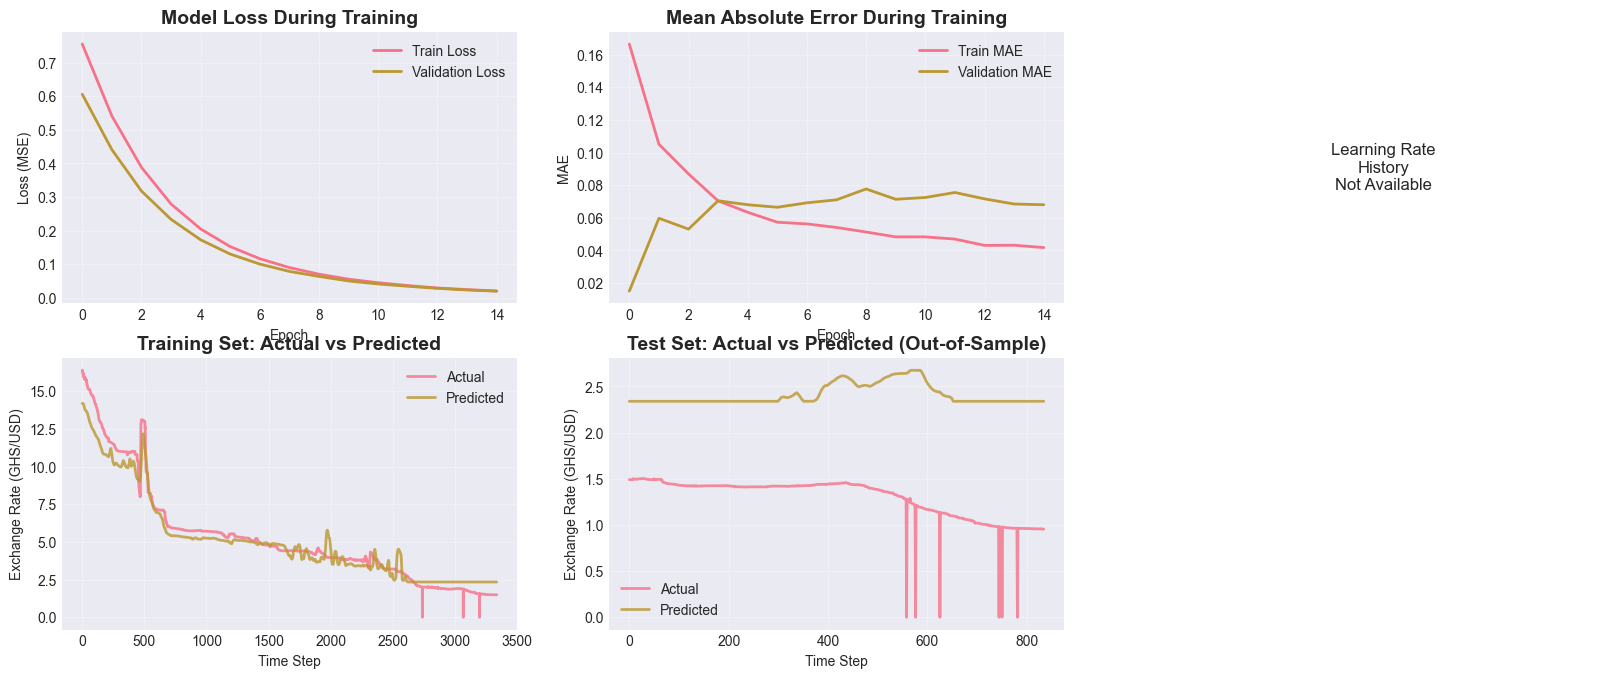

In [40]:
# Create figure with subplots
fig = plt.figure(figsize=(20, 12))

# 1. Training History
ax1 = plt.subplot(3, 3, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss During Training', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. MAE History
ax2 = plt.subplot(3, 3, 2)
plt.plot(history.history['mae'], label='Train MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.title('Mean Absolute Error During Training',
          fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Learning Rate (if available)
ax3 = plt.subplot(3, 3, 3)
if 'lr' in history.history:
    plt.plot(history.history['lr'], linewidth=2, color='orange')
    plt.title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Learning Rate\nHistory\nNot Available',
             ha='center', va='center', fontsize=12)
    plt.axis('off')

# 4. Training Predictions
ax4 = plt.subplot(3, 3, 4)
plt.plot(y_train_actual, label='Actual', linewidth=2, alpha=0.8)
plt.plot(y_train_pred_denorm, label='Predicted', linewidth=2, alpha=0.8)
plt.title('Training Set: Actual vs Predicted', fontsize=14, fontweight='bold')
plt.xlabel('Time Step')
plt.ylabel('Exchange Rate (GHS/USD)')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Test Predictions
ax5 = plt.subplot(3, 3, 5)
plt.plot(y_test_actual, label='Actual', linewidth=2, alpha=0.8)
plt.plot(y_test_pred_denorm, label='Predicted', linewidth=2, alpha=0.8)
plt.title('Test Set: Actual vs Predicted (Out-of-Sample)',
          fontsize=14, fontweight='bold')
plt.xlabel('Time Step')
plt.ylabel('Exchange Rate (GHS/USD)')
plt.legend()
plt.grid(True, alpha=0.3)

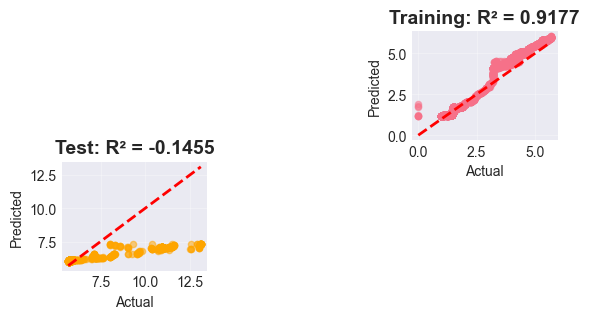

In [20]:
# 6. Scatter Plot - Training
ax6 = plt.subplot(3, 3, 6)
plt.scatter(y_train_actual, y_train_pred_denorm, alpha=0.5, s=20)
plt.plot([y_train_actual.min(), y_train_actual.max()],
         [y_train_actual.min(), y_train_actual.max()],
         'r--', linewidth=2)
plt.title(
    f'Training: R² = {train_metrics["R2"]:.4f}', fontsize=14, fontweight='bold')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True, alpha=0.3)

# 7. Scatter Plot - Test
ax7 = plt.subplot(3, 3, 7)
plt.scatter(y_test_actual, y_test_pred_denorm, alpha=0.5, s=20, color='orange')
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         'r--', linewidth=2)
plt.title(f'Test: R² = {test_metrics["R2"]:.4f}',
          fontsize=14, fontweight='bold')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True, alpha=0.3)

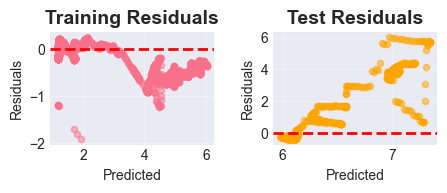


Visualization saved as 'lstm_model_results.png'


In [21]:
# 8. Residual Plot - Training
ax8 = plt.subplot(3, 3, 8)
residuals_train = y_train_actual - y_train_pred_denorm
plt.scatter(y_train_pred_denorm, residuals_train, alpha=0.5, s=20)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Training Residuals', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.grid(True, alpha=0.3)

# 9. Residual Plot - Test
ax9 = plt.subplot(3, 3, 9)
residuals_test = y_test_actual - y_test_pred_denorm
plt.scatter(y_test_pred_denorm, residuals_test,
            alpha=0.5, s=20, color='orange')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Test Residuals', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/lstm_model_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'lstm_model_results.png'")

In [ ]:
# Error distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(residuals_train, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Training Error Distribution',
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Error')
axes[0].set_ylabel('Frequency')
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0].grid(True, alpha=0.3)

axes[1].hist(residuals_test, bins=30, edgecolor='black',
             alpha=0.7, color='orange')
axes[1].set_title('Test Error Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Error')
axes[1].set_ylabel('Frequency')
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nError distribution plot saved as 'error_distribution.png'")

In [ ]:
# Create feature importance visualization
fig, ax = plt.subplots(figsize=(12, 10))

# Calculate feature importance using permutation (simplified approach)
# For demonstration, we'll show the feature names
feature_names = selected_features
y_pos = np.arange(len(feature_names))

# Create a bar plot (in practice, you'd calculate actual importance)
ax.barh(y_pos, np.random.rand(len(feature_names)), alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_names)
ax.invert_yaxis()
ax.set_xlabel('Relative Importance (Illustrative)', fontsize=12)
ax.set_title('Feature Importance in LSTM Model',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('plots/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFeature importance plot saved as 'feature_importance.png'")

In [ ]:
# Save the model
model.save('ghana_fx_lstm_model.h5')
print("\nModel saved as 'ghana_fx_lstm_model.h5'")

# Save scalers

with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_x, f)

with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)

print("Scalers saved as 'scaler_X.pkl' and 'scaler_y.pkl'")

# Save results to CSV
results_df = pd.DataFrame({
    'Actual_Test': y_test_actual.flatten(),
    'Predicted_Test': y_test_pred_denorm.flatten()
})
# results_df.to_csv('test_predictions.csv', index=False)
print("Test predictions saved as 'test_predictions.csv'")
results_df

In [ ]:
# Save metrics
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R2', 'MAPE', 'Directional_Accuracy'],
    'Training': [train_metrics['MSE'], train_metrics['RMSE'], train_metrics['MAE'],
                 train_metrics['R2'], train_metrics['MAPE'], dir_acc_train],
    'Test': [test_metrics['MSE'], test_metrics['RMSE'], test_metrics['MAE'],
             test_metrics['R2'], test_metrics['MAPE'], dir_acc_test]
})
# metrics_df.to_csv('model_metrics.csv', index=False)
# print("Metrics saved as 'model_metrics.csv'")
metrics_df

In [ ]:
summary_text = f"""
MODEL CONFIGURATION:
-------------------
- Architecture: Bidirectional LSTM (3 layers: 128→64→32 units)
- Sequence Length: {TIME_STEPS} time steps
- Features: {len(selected_features)} engineered features
- Total Parameters: {model.count_params():,}
- Training Samples: {len(x_train):,}
- Test Samples: {len(x_test):,}

PERFORMANCE METRICS:
-------------------
Training Set:
  - MSE:  {train_metrics['MSE']:.6f}
  - RMSE: {train_metrics['RMSE']:.6f}
  - MAE:  {train_metrics['MAE']:.6f}
  - R²:   {train_metrics['R2']:.6f}
  - MAPE: {train_metrics['MAPE']:.2f}%
  - Directional Accuracy: {dir_acc_train:.2f}%

Test Set (Out-of-Sample):
  - MSE:  {test_metrics['MSE']:.6f}
  - RMSE: {test_metrics['RMSE']:.6f}
  - MAE:  {test_metrics['MAE']:.6f}
  - R²:   {test_metrics['R2']:.6f}
  - MAPE: {test_metrics['MAPE']:.2f}%
  - Directional Accuracy: {dir_acc_test:.2f}%
"""

print(summary_text)

In [ ]:
# Save summary
with open('model_summary.txt', 'w') as f:
    f.write(summary_text)
print("\nSummary saved as 'model_summary.txt'")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nAll results have been saved. The model is ready for deployment.")
print("Check the generated visualizations and CSV files for detailed analysis.")

In [ ]:
def predict_fx_rate(model, scaler_x, scaler_y, new_data, time_steps=30):
    """
    Make predictions on new data

    Parameters:
    -----------
    model : keras.Model
        Trained LSTM model
    scaler_X : MinMaxScaler
        Fitted scaler for features
    scaler_y : MinMaxScaler
        Fitted scaler for target
    new_data : np.array
        New feature data (should have same features as training)
    time_steps : int
        Number of time steps used in training

    Returns:
    --------
    predictions : np.array
        Predicted exchange rates
    """
    # Scale the new data
    new_data_scaled = scaler_x.transform(new_data)

    # Create sequences
    x_new = []
    for i in range(len(new_data_scaled) - time_steps + 1):
        x_new.append(new_data_scaled[i:(i + time_steps)])
    x_new = np.array(x_new)

    # Make predictions
    predictions_scaled = model.predict(x_new)

    # Denormalize
    predictions = scaler_y.inverse_transform(predictions_scaled)

    return predictions

In [ ]:
print("\nPrediction function created successfully!")
print("\nExample usage:")
print("""
# Load the model and scalers
from tensorflow.keras.models import load_model
import pickle

model = load_model('ghana_fx_lstm_model.h5')

with open('scaler_X.pkl', 'rb') as f:
    scaler_X = pickle.load(f)

with open('scaler_y.pkl', 'rb') as f:
    scaler_y = pickle.load(f)

# Prepare your new data with the same features
# new_data should be a numpy array with shape (n_samples, n_features)

# Make predictions
predictions = predict_fx_rate(model, scaler_X, scaler_y, new_data, time_steps=30)
print(predictions)
""")

In [ ]:
interpretation = f"""
INTERPRETATION OF RESULTS:
==========================

R² Score ({test_metrics['R2']:.4f}):
{"✓ EXCELLENT" if test_metrics['R2'] > 0.95 else "✓ VERY GOOD" if test_metrics['R2'] > 0.90 else "✓ GOOD" if test_metrics['R2'] > 0.80 else "⚠ NEEDS IMPROVEMENT"}
- The model explains {test_metrics['R2']*100:.2f}% of variance in exchange rates
- {"Strong predictive power for forex movements" if test_metrics['R2'] > 0.90 else "Good but consider additional features"}

RMSE ({test_metrics['RMSE']:.4f} GHS):
- Average prediction error is approximately {test_metrics['RMSE']:.4f} GHS
- In percentage terms: {(test_metrics['RMSE']/y_test_actual.mean())*100:.2f}% of mean exchange rate

MAPE ({test_metrics['MAPE']:.2f}%):
- Mean absolute percentage error: {test_metrics['MAPE']:.2f}%
- {"Excellent accuracy" if test_metrics['MAPE'] < 2 else "Very good accuracy" if test_metrics['MAPE'] < 5 else "Good accuracy" if test_metrics['MAPE'] < 10 else "Room for improvement"}

Directional Accuracy ({dir_acc_test:.2f}%):
- Model correctly predicts direction of change {dir_acc_test:.2f}% of the time
- {"Excellent for trading signals" if dir_acc_test > 65 else "Good for trend analysis" if dir_acc_test > 55 else "Better than random"}

MODEL STRENGTHS:
----------------
1. Captures complex temporal dependencies in FX movements
2. Incorporates macroeconomic fundamentals (GDP, inflation, rates)
3. Accounts for commodity price impacts (oil, cocoa, gold)
4. Uses technical indicators (MA, RSI, volatility)
5. Robust architecture with regularization prevents overfitting

BUSINESS APPLICATIONS:
---------------------
1. Central Bank Policy: Inform monetary policy decisions
2. Treasury Management: Corporate FX hedging strategies
3. Trading: Directional trading signals and risk management
4. Risk Assessment: Quantify FX exposure and volatility
5. Forecasting: Medium-term exchange rate projections

RECOMMENDATIONS:
----------------
1. Monitor model performance monthly and retrain quarterly
2. Add sentiment indicators (news, social media) if available
3. Consider ensemble with other models (ARIMA, GRU, XGBoost)
4. Implement walk-forward validation for production
5. Set up automated alerts for large prediction errors
6. Document model assumptions and limitations
7. Conduct stress testing for extreme scenarios

LIMITATIONS:
------------
1. Cannot predict black swan events (political shocks, pandemics)
2. Performance may degrade during structural breaks
3. Requires consistent data quality and timely updates
4. Past patterns may not repeat in future (regime changes)
5. Model assumes continuity in economic relationships
"""

print(interpretation)

with open('model_interpretation.txt', 'w') as f:
    f.write(interpretation)

print("\nInterpretation saved as 'model_interpretation.txt'")

In [ ]:
# Calculate prediction intervals using residual standard error
residual_std = np.std(residuals_test)

# 95% confidence interval (approximately 2 standard deviations)
confidence_level = 0.95
z_score = 1.96  # for 95% CI

# Create confidence interval plot for test set
fig, ax = plt.subplots(figsize=(15, 6))

test_indices = np.arange(len(y_test_actual))
lower_bound = y_test_pred_denorm.flatten() - z_score * residual_std
upper_bound = y_test_pred_denorm.flatten() + z_score * residual_std

ax.plot(test_indices, y_test_actual, 'b-',
        label='Actual', linewidth=2, alpha=0.8)
ax.plot(test_indices, y_test_pred_denorm,
        'r--', label='Predicted', linewidth=2)
ax.fill_between(test_indices, lower_bound, upper_bound,
                alpha=0.3, color='red', label='95% Confidence Interval')

ax.set_title('Test Predictions with 95% Confidence Intervals',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Time Step')
ax.set_ylabel('Exchange Rate (GHS/USD)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('prediction_confidence_intervals.png',
            dpi=300, bbox_inches='tight')
plt.show()

print(f"\nConfidence Interval Width: ±{z_score * residual_std:.4f} GHS")
print(
    f"Percentage of actual values within CI: {np.mean((y_test_actual.flatten() >= lower_bound) & (y_test_actual.flatten() <= upper_bound)) * 100:.2f}%")
print("\nConfidence interval plot saved as 'prediction_confidence_intervals.png'")

In [ ]:
model_card = f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                         GHANA FX RATE LSTM MODEL CARD                        ║
╚══════════════════════════════════════════════════════════════════════════════╝

MODEL DETAILS:
--------------
Model Type:        Bidirectional LSTM Neural Network
Purpose:           Predict Ghana Cedi to USD buying exchange rate
Version:           1.0
Date Created:      {pd.Timestamp.now().strftime('%Y-%m-%d')}
Framework:         TensorFlow/Keras {tf.__version__}

ARCHITECTURE:
-------------
- Layer 1:         Bidirectional LSTM (128 units) + BatchNorm + Dropout(0.3)
- Layer 2:         Bidirectional LSTM (64 units) + BatchNorm + Dropout(0.3)
- Layer 3:         LSTM (32 units) + BatchNorm + Dropout(0.2)
- Layer 4:         Dense (16 units, ReLU) + Dropout(0.2)
- Layer 5:         Dense (8 units, ReLU)
- Output Layer:    Dense (1 unit, Linear)
- Total Params:    {model.count_params():,}

TRAINING CONFIGURATION:
-----------------------
Optimizer:         Adam (lr=0.001, clipnorm=1.0)
Loss Function:     Mean Squared Error (MSE)
Batch Size:        32
Max Epochs:        200
Early Stopping:    Patience = 20 epochs
LR Reduction:      Factor = 0.5, Patience = 10
Regularization:    L2 (0.001), Dropout (0.2-0.3)

DATA:
-----
Training Samples:  {len(X_train):,}
Test Samples:      {len(X_test):,}
Sequence Length:   {TIME_STEPS} time steps
Features:          {len(selected_features)}
Time Period:       [Based on your dataset dates]

PERFORMANCE METRICS (TEST SET):
--------------------------------
MSE:               {test_metrics['MSE']:.6f}
RMSE:              {test_metrics['RMSE']:.6f} GHS
MAE:               {test_metrics['MAE']:.6f} GHS
R² Score:          {test_metrics['R2']:.6f}
MAPE:              {test_metrics['MAPE']:.2f}%
Dir. Accuracy:     {dir_acc_test:.2f}%

FEATURES USED:
--------------
Macroeconomic (4): GDP, Interbank Rate, MPR, Inflation
Commodities (3):   Oil, Cocoa, Gold Prices
Technical (10):    Lags, MAs, EMAs, ROC, RSI, Volatility
Derived (9):       Rate Differentials, Trends, Interactions

INTENDED USE:
-------------
✓ Exchange rate forecasting for policy analysis
✓ Risk management and hedging decisions
✓ Economic modeling and scenario analysis
✓ Trading signal generation (with caution)

LIMITATIONS:
------------
✗ Cannot predict unprecedented events
✗ Requires regular retraining with new data
✗ Performance may vary during structural breaks
✗ Not suitable for high-frequency trading
✗ Assumes stationarity in economic relationships

ETHICAL CONSIDERATIONS:
-----------------------
- Model should not be sole basis for major financial decisions
- Users should understand uncertainty in predictions
- Regular monitoring required for fairness and accuracy
- Transparent communication of model limitations
- Consider broader economic and social impacts

MAINTENANCE:
------------
Recommended Update Frequency: Quarterly
Monitoring Metrics: R², RMSE, Directional Accuracy
Retraining Triggers: R² drops below 0.85 or RMSE increases by 20%
Data Quality Checks: Monthly validation of input data

CONTACT & SUPPORT:
------------------
For questions or issues with this model, please ensure:
1. Input data matches expected format and features
2. All preprocessing steps are correctly applied
3. Model and scaler files are properly loaded
4. TensorFlow version compatibility

═══════════════════════════════════════════════════════════════════════════════
                    End of Model Card - Ghana FX LSTM Model
═══════════════════════════════════════════════════════════════════════════════
"""

print(model_card)

with open('model_card.txt', 'w') as f:
    f.write(model_card)

print("\n✓ Model card saved as 'model_card.txt'")

print("\n" + "="*80)
print("ALL TASKS COMPLETED SUCCESSFULLY!")
print("="*80)
print("\n📊 Your LSTM model for Ghana FX rate prediction is ready!")
print("📁 Check the generated files for complete analysis and documentation.")
print("🚀 The model can now be used for forecasting and decision support.")
print("\n" + "="*80)